In [ ]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.mixture import GaussianMixture
from skimage import io

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
image = cv2.imread('/content/gdrive/MyDrive/311068.jpg')
image_color = image.copy()
height, width, channels = image.shape
data = np.reshape(image, (height * width, channels))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Using Predefined**

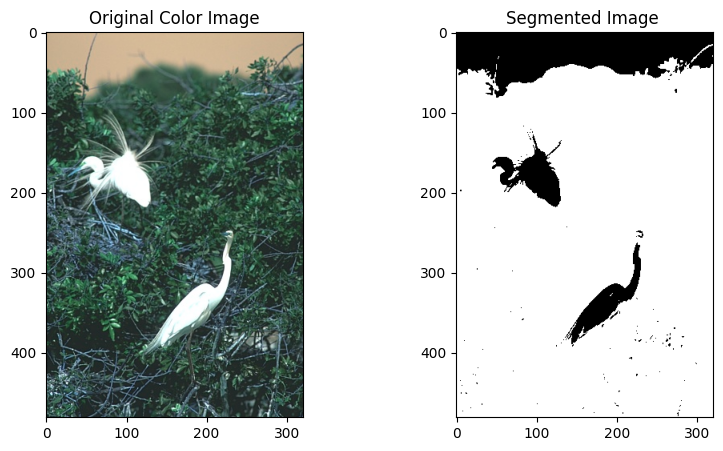

In [ ]:
n_components = 2
model = GaussianMixture(n_components=n_components, random_state=42,covariance_type='tied')


model.fit(data)

segmented = model.predict(data)
segmented_image = segmented.reshape((height, width))


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(image_color)
plt.title('Original Color Image')

plt.subplot(1, 3, 2)
plt.imshow(segmented_image, cmap='binary')  # Use 'binary' colormap for black and white
plt.title('Segmented Image ')

plt.show()

# **From Scratch**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from sklearn.mixture import GaussianMixture
from skimage import io

from google.colab.patches import cv2_imshow
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import cv2


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
image = cv2.imread('/content/gdrive/MyDrive/311068.jpg')
image_color = image.copy()
height, width, channels = image.shape
data = np.reshape(image, (height * width, channels))
n_components=2

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


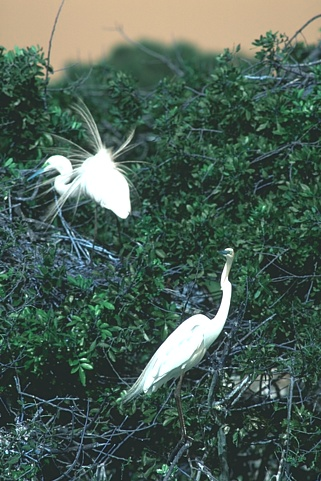

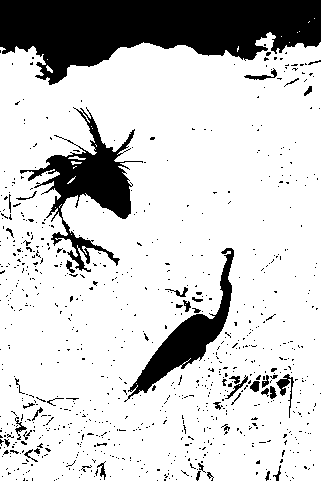

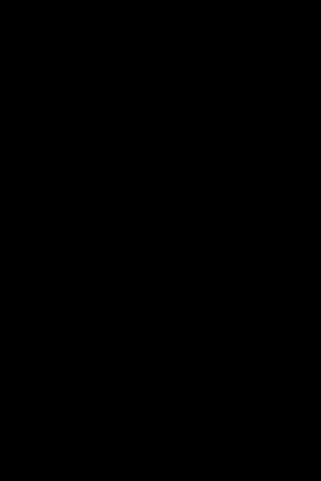

In [ ]:

def initialize_parameters(num_clusters, data):
    # Initialize using K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(data)
    means = kmeans.cluster_centers_

    covariances = [np.cov(data[labels == i].T) + 1e-6 * np.eye(data.shape[1]) for i in range(num_clusters)]
    mixing_coefficients = np.ones(num_clusters) / num_clusters

    return means, covariances, mixing_coefficients

def stopping_condition(old_likelihood, new_likelihood, threshold=1e-4):
    # Stopping condition based on maximum likelihood improvement
    improvement = new_likelihood - old_likelihood
    return improvement < threshold
##############################################################

def e_step(data, means, covariances, mixing_coefficients):
    num_clusters = len(means)
    likelihoods = np.zeros((len(data), num_clusters))

    for i in range(num_clusters):
        distribution = multivariate_normal(mean=means[i], cov=covariances[i])
        likelihoods[:, i] = distribution.pdf(data)

    weighted_likelihoods = likelihoods * mixing_coefficients
    probabilities = weighted_likelihoods / np.sum(weighted_likelihoods, axis=1, keepdims=True)

    return probabilities


def m_step(data, probabilities):
    num_clusters = probabilities.shape[1]
    total_probabilities = np.sum(probabilities, axis=0)
    means = np.dot(probabilities.T, data) / total_probabilities[:, np.newaxis]

    covariances = [np.cov(data.T, aweights=probabilities[:, i]) for i in range(num_clusters)]

    mixing_coefficients = total_probabilities / len(data)

    return means, covariances, mixing_coefficients

# Run EM algorithm
def em_algorithm(data, num_clusters, max_iterations=100, epsilon=1e-4):
    means, covariances, mixing_coefficients = initialize_parameters(num_clusters, data)
    old_likelihood = -np.inf

    for iteration in range(max_iterations):
        # E-step
        probabilities = e_step(data, means, covariances, mixing_coefficients)

        # M-step
        new_means, new_covariances, new_mixing_coefficients = m_step(data, probabilities)

        # Calculate likelihood for stopping condition
        likelihood = np.sum(np.log(np.sum(probabilities * mixing_coefficients, axis=1)))

        # Check convergence
        if stopping_condition(old_likelihood, likelihood, epsilon):
            break

        means, covariances, mixing_coefficients = new_means, new_covariances, new_mixing_coefficients
        old_likelihood = likelihood

    return means, covariances, mixing_coefficients, probabilities
###################


def segment_image(image, means, probabilities):
    # Assign each pixel to the cluster with the highest probability
    labels = np.argmax(probabilities, axis=1)

    # Create binary images separating foreground and background
    object_binary = np.zeros_like(image)
    background_binary = np.zeros_like(image)

    # Choose the cluster with the highest mixing coefficient as the object
    object_cluster = np.argmax(np.sum(probabilities, axis=0))

    # Create binary mask for object and background
    object_mask = labels == object_cluster
    background_mask = ~object_mask

    # Set pixels corresponding to the object to black
    object_binary[object_mask] = 255

    # Set pixels corresponding to the background to white
    background_binary[background_mask] = 0

    return object_binary, background_binary


# Set the number of clusters
num_clusters = 2  # You can choose the desired number of clusters

# Run EM algorithm
means, covariances, mixing_coefficients, probabilities = em_algorithm(data, num_clusters)


# Segment the image
object_binary, background_binary = segment_image(data, means, probabilities)

# Reshape binary images to original shape
object_image = object_binary.reshape((height, width, channels))
background_image = background_binary.reshape((height, width, channels))

# Display the original and segmented images
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
cv2_imshow(cv2.cvtColor(object_image.astype(np.uint8), cv2.COLOR_RGB2BGR))
cv2_imshow(cv2.cvtColor(background_image.astype(np.uint8), cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()